# Controle PID - Motor DC

## Parâmetros e Constantes
- Da caracterização do Motor em Bancada
- Datasheet do Fornecedor (Pololu)

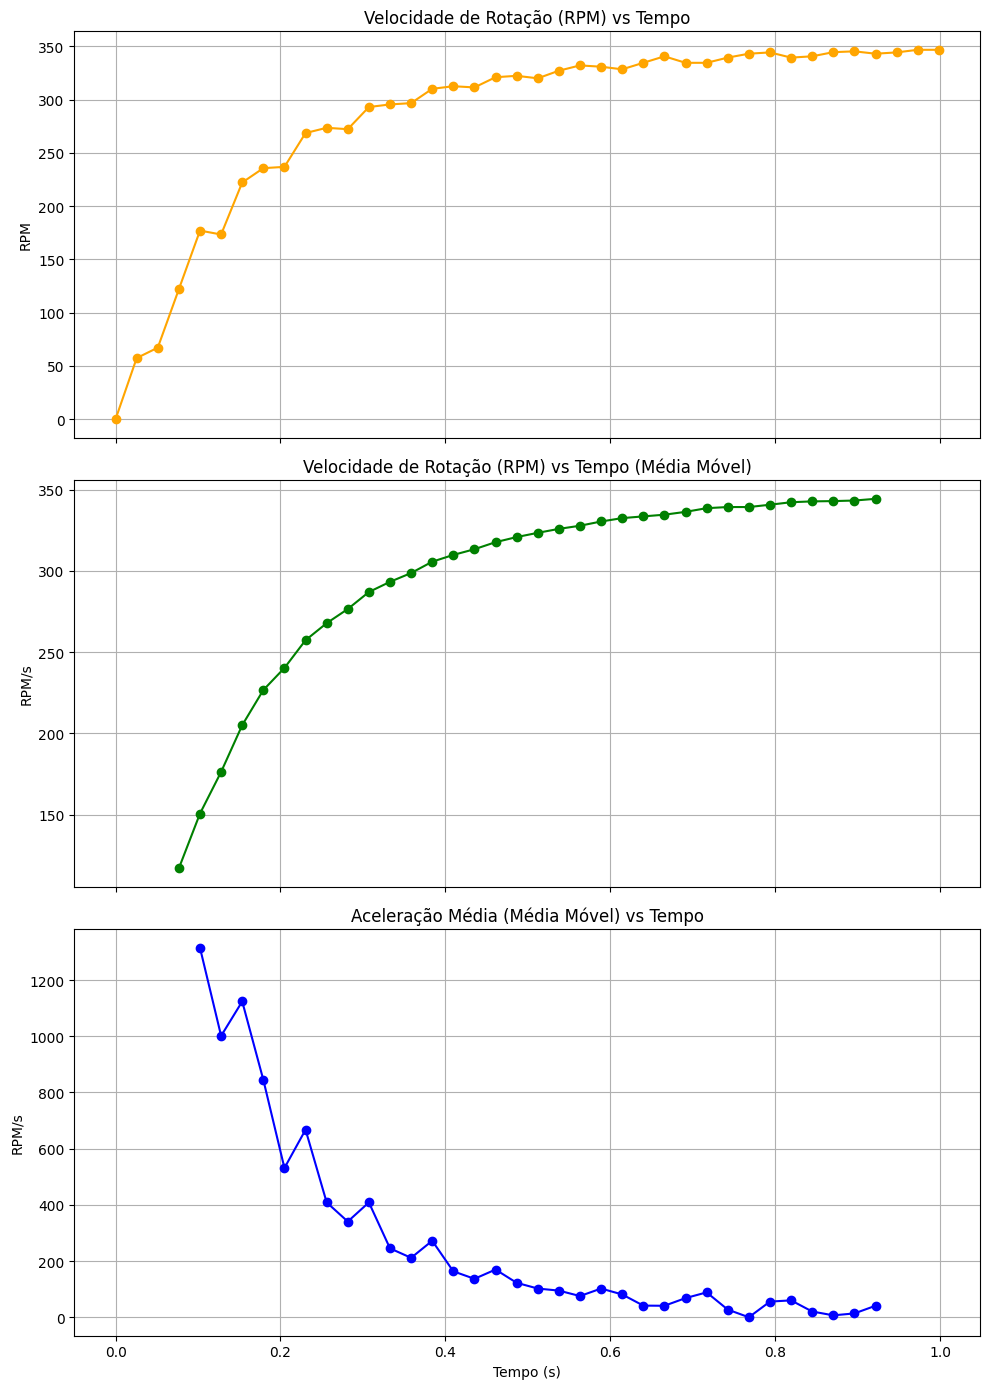

In [1]:
# Caracterização em Bancada
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Dados obtidos na bancada
dados = [
    (0.000000,   0), (0.025600,  47), (0.051201,  55), (0.076800, 100),
    (0.102400, 145), (0.127998, 142), (0.153600, 182), (0.179200, 193),
    (0.204800, 194), (0.230400, 220), (0.255996, 224), (0.281600, 223),
    (0.307200, 240), (0.332800, 242), (0.358400, 243), (0.384000, 254),
    (0.409600, 256), (0.435192, 255), (0.460800, 263), (0.486400, 264),
    (0.511992, 262), (0.537600, 268), (0.563200, 272), (0.588800, 271),
    (0.614400, 269), (0.640000, 274), (0.665600, 279), (0.691200, 274),
    (0.716800, 274), (0.742400, 278), (0.768000, 281), (0.793600, 282),
    (0.819200, 278), (0.844800, 279), (0.870384, 282), (0.896000, 283),
    (0.921600, 281), (0.947200, 282), (0.972800, 284), (0.998400, 284)
]

# Extração de vetores de tempo e pulsos
tempos = np.array([t for t, _ in dados])
pulsos = np.array([p for _, p in dados])

# Cálculo de Δt (diferenças de tempo)
dts = np.diff(tempos, prepend=tempos[0])
if dts[0] == 0:
    dts[0] = dts[1]

# Pulsos por volta
PULSOS_POR_VOLTA = 1920

# Conversão para RPM
rpm = (pulsos / PULSOS_POR_VOLTA) * (60 / dts)

# ----- Aceleração média com média móvel -----
def moving_average(x, window_size):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

window = 7 # número de amostras na média
rpm_ma = moving_average(rpm, window)
tempos_ma = moving_average(tempos, window)
acc_ma = np.diff(rpm_ma) / np.diff(tempos_ma) # Aproximação de aceleração média na janela
temp_acc_ma = tempos_ma[1:]

# ----- Aceleração instantânea -----
acc_raw = np.diff(rpm, prepend=rpm[0]) / dts

# ----- Plot  -----
fig, axs = plt.subplots(3, 1, figsize=(10, 14), sharex=True)

axs[0].plot(tempos, rpm, marker='o', color='orange')
axs[0].set_title('Velocidade de Rotação (RPM) vs Tempo')
axs[0].set_ylabel('RPM')
axs[0].grid(True)

axs[1].plot(tempos_ma, rpm_ma, marker='o', color='green')
axs[1].set_title('Velocidade de Rotação (RPM) vs Tempo (Média Móvel)')
axs[1].set_ylabel('RPM/s')
axs[1].grid(True)

axs[2].plot(temp_acc_ma, acc_ma, marker='o', color='blue')
axs[2].set_title('Aceleração Média (Média Móvel) vs Tempo')
axs[2].set_xlabel('Tempo (s)')
axs[2].set_ylabel('RPM/s')
axs[2].grid(True)

plt.tight_layout()
plt.show()


=== Especificações do Motor ===
Tensão nominal: 12V
Torque de parada: 110 oz-in
Corrente de parada: 5000 mA
Velocidade em vazio: 350 RPM
Corrente em vazio: 300 mA

=== Resultados Calculados ===
Inclinação de TorqueVsCurrent: 42.7273 mA/(oz-in)
Recíproco (Constante de Torque): 0.0234 (oz-in)/mA

Potência mecânica de saída máxima: 7.12 W
Torque para potência máxima: 54.9 oz-in
Corrente para potência máxima: 2645.3 mA

Resistência do motor: 2.40 ohms


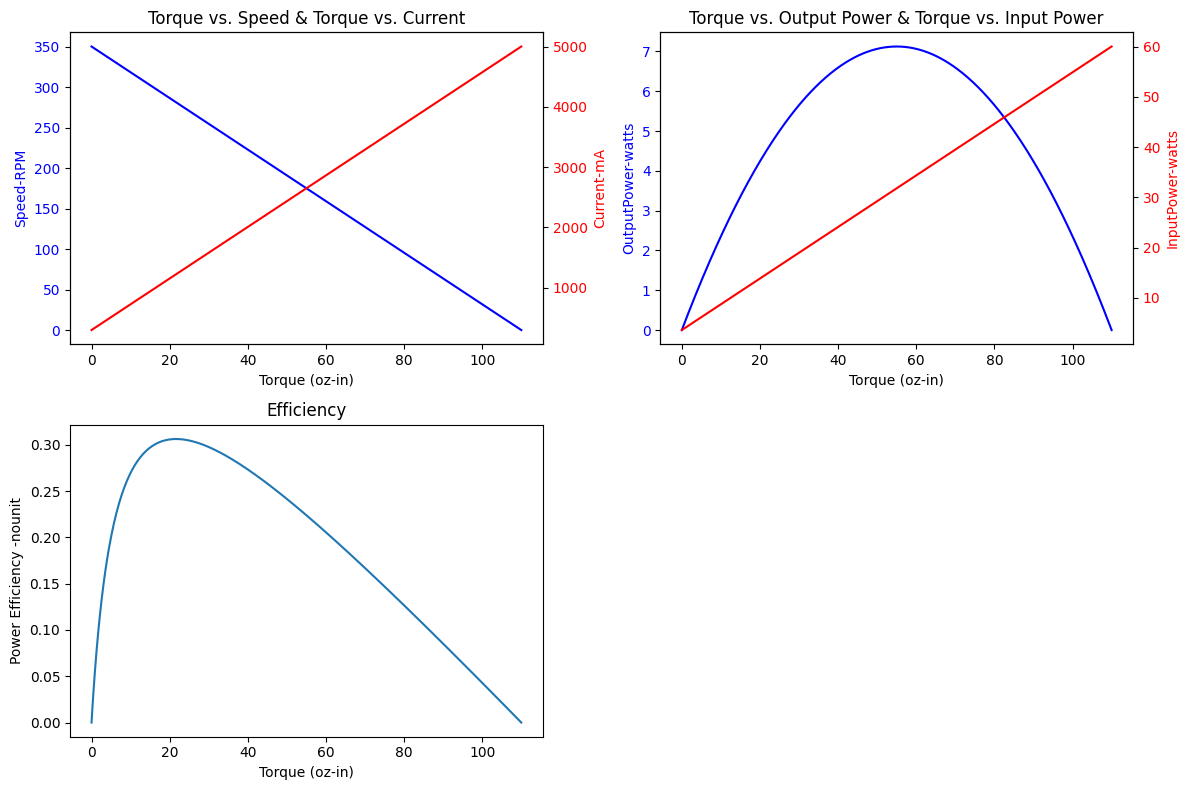

In [2]:
#Datasheet Pololu - Item#1443
import numpy as np
import matplotlib.pyplot as plt

def pololu_motor_plot_gen_aam_v2():
    plt.close('all')
    discrete_bins = 500  # Número de bins para plotagem e cálculos
    
    # Dados do motor conforme a tabela fornecida (usando valores para 12V)
    stall_torque = 110    # oz-in
    stall_current = 5000  # mA
    rated_voltage = 12    # V
    no_load_current = 300 # mA
    no_load_speed = 350   # RPM
    
    # Cálculos básicos
    resistance = rated_voltage / (stall_current / 1000)
    
    # Linhas para plotagem
    torque_line = np.linspace(0, stall_torque, discrete_bins)
    current_line = np.linspace(no_load_current, stall_current, discrete_bins)
    speed_line = np.linspace(no_load_speed, 0, discrete_bins)
    
    # Constante de torque
    slope_torque_vs_current = (stall_current - no_load_current) / stall_torque
    
    # Potências
    output_power = 0.00074 * torque_line * speed_line  # Potência mecânica de saída em watts
    input_power = current_line * rated_voltage / 1000  # Potência elétrica de entrada em watts
    
    # Criando a figura
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Torque vs Velocidade e Torque vs Corrente
    plt.subplot(2, 2, 1)
    ax1 = plt.gca()
    ax1.plot([0, stall_torque], [no_load_speed, 0], 'b-')
    ax1.set_xlabel('Torque (oz-in)')
    ax1.set_ylabel('Speed-RPM', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.plot([0, stall_torque], [no_load_current, stall_current], 'r-')
    ax2.set_ylabel('Current-mA', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    plt.title('Torque vs. Speed & Torque vs. Current')
    
    # Subplot 2: Torque vs Potência de Saída e Torque vs Potência de Entrada
    plt.subplot(2, 2, 2)
    ax3 = plt.gca()
    ax3.plot(torque_line, output_power, 'b-')
    ax3.set_xlabel('Torque (oz-in)')
    ax3.set_ylabel('OutputPower-watts', color='b')
    ax3.tick_params(axis='y', labelcolor='b')
    
    ax4 = ax3.twinx()
    ax4.plot(torque_line, input_power, 'r-')
    ax4.set_ylabel('InputPower-watts', color='r')
    ax4.tick_params(axis='y', labelcolor='r')
    plt.title('Torque vs. Output Power & Torque vs. Input Power')
    
    # Subplot 3: Eficiência de Potência
    plt.subplot(2, 2, 3)
    power_eff = output_power / input_power
    plt.plot(torque_line, power_eff)
    plt.xlabel('Torque (oz-in)')
    plt.ylabel('Power Efficiency -nounit')
    plt.title('Efficiency')
    
    plt.tight_layout()
    
    # Saída de informações
    print("\n=== Especificações do Motor ===")
    print(f"Tensão nominal: {rated_voltage}V")
    print(f"Torque de parada: {stall_torque} oz-in")
    print(f"Corrente de parada: {stall_current} mA")
    print(f"Velocidade em vazio: {no_load_speed} RPM")
    print(f"Corrente em vazio: {no_load_current} mA")
    
    print("\n=== Resultados Calculados ===")
    print(f"Inclinação de TorqueVsCurrent: {slope_torque_vs_current:.4f} mA/(oz-in)")
    print(f"Recíproco (Constante de Torque): {1/slope_torque_vs_current:.4f} (oz-in)/mA")
    
    max_power_idx = np.argmax(output_power)
    print(f"\nPotência mecânica de saída máxima: {output_power[max_power_idx]:.2f} W")
    print(f"Torque para potência máxima: {torque_line[max_power_idx]:.1f} oz-in")
    print(f"Corrente para potência máxima: {current_line[max_power_idx]:.1f} mA")
    print(f"\nResistência do motor: {resistance:.2f} ohms")
    
    plt.show()

# Chamada da função
if __name__ == "__main__":
    pololu_motor_plot_gen_aam_v2()

## Função de Transferência
- Comparando os Resultados obtidos abaixo utilizaremos uma função de 1a Ordem, pois se aproxima da curva de posição real


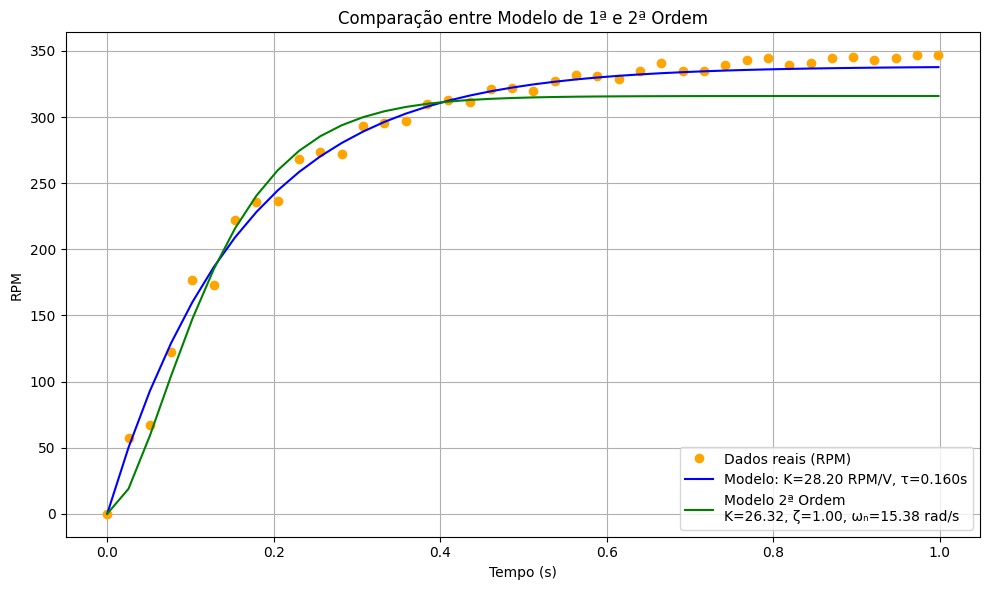

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Modelo exponencial de resposta de 1ª ordem
def modelo_motor(t, K, tau):
    return K * (1 - np.exp(-t / tau))

# Ajuste até ~0.6s (região transitória)
idx_fit = tempos < 0.6
t_fit = tempos[idx_fit]
rpm_fit = rpm[idx_fit]

# Ajuste de curva exponencial
params, _ = curve_fit(modelo_motor, t_fit, rpm_fit, bounds=(0, [1000, 2]))
K_rpm, tau = params

# Normalização por tensão aplicada
rated_voltage = 12  # V
K_rpm_v = K_rpm / rated_voltage

# Modelo com ganho normalizado (RPM/V)
def modelo_normalizado(t, K_v, tau):
    return rated_voltage * K_v * (1 - np.exp(-t / tau))

# Geração da curva teórica
rpm_modelo_1ordem = modelo_normalizado(tempos, K_rpm_v, tau)

def modelo_2ordem(t, K, zeta, omega_n):
    omega_d = omega_n * np.sqrt(1 - zeta**2)
    exp_term = np.exp(-zeta * omega_n * t)
    seno_term = np.sin(omega_d * t)
    cos_term = np.cos(omega_d * t)
    fase_term = (zeta / np.sqrt(1 - zeta**2)) * seno_term
    resposta = K * (1 - exp_term * (cos_term + fase_term))
    return rated_voltage * resposta

# Ajuste do modelo 2ª ordem
initial_guess = [30,1,20]
params_2ordem, _ = curve_fit(modelo_2ordem, t_fit, rpm_fit, p0=initial_guess, bounds=(0, [100, 1, 200]))
K2, zeta2, omega_n2 = params_2ordem
rpm_model_2ordem = modelo_2ordem(tempos, K2, zeta2, omega_n2)

# Plot comparativo
plt.figure(figsize=(10, 6))
plt.plot(tempos, rpm, 'o', label='Dados reais (RPM)', color='orange')
plt.plot(tempos, rpm_modelo_1ordem, '-', label=f'Modelo: K={K_rpm_v:.2f} RPM/V, τ={tau:.3f}s', color='blue')
plt.plot(tempos, rpm_model_2ordem, '-', label=f'Modelo 2ª Ordem\nK={K2:.2f}, ζ={zeta2:.2f}, ωₙ={omega_n2:.2f} rad/s', color='green')
plt.title('Comparação entre Modelo de 1ª e 2ª Ordem')
plt.xlabel('Tempo (s)')
plt.ylabel('RPM')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

$$\frac{28.2}{0.16+s}$$

## Introducao da inercia da carga

--- SISTEMA DE TESTE (EXPERIMENTAL) ---
Inércia do disco de teste: 2.111e-03 kg.m²
Inércia total do teste (Motor + Disco): 2.112e-03 kg.m²
Constante de tempo medida (tau_teste): 0.160 s

--- SISTEMA FINAL (COM CARRETEL E CARGA) ---
Inércia do carretel: 2.188e-05 kg.m²
Inércia refletida da carga: 3.750e-05 kg.m²
Inércia total final: 6.111e-05 kg.m²
Constante de tempo estimada (tau_final): 0.005 s


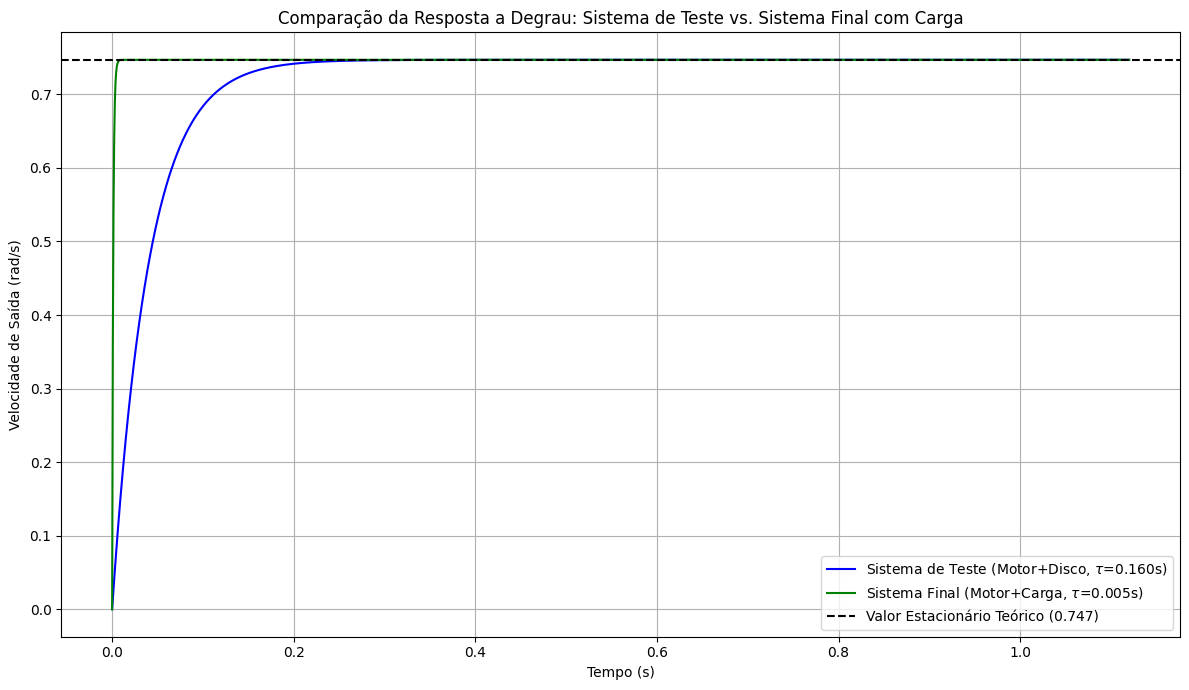


--- Funções de Transferência Finais ---

FT para VELOCIDADE (com carga final):
<TransferFunction>: sys[11]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


    2.953
--------------
0.004629 s + 1


FT para POSIÇÃO (com carga final):
<TransferFunction>: sys[18]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


     2.953
----------------
0.004629 s^2 + s



In [4]:
import numpy as np
import control as co
import matplotlib.pyplot as plt

# --- 1. PARÂMETROS BASE E DADOS EXPERIMENTAIS ---
K_motor_rpm_v = 28.2    # Ganho RPM/V (do ajuste de curva)
# tau_teste é a constante de tempo medida no ensaio com o disco
tau_teste = 0.16        # s 

# Converter ganho para rad/s/V para consistência com unidades SI
K_motor_rad_v = K_motor_rpm_v * (2 * np.pi / 60)

# --- 2. CÁLCULO DAS INÉRCIAS ---

# Inércia do motor (do CAD)
J_motor = 1.7387e-6     # kg.m² 

# Parâmetros do Disco de Teste (usado no ensaio)
raio_disco = 0.05
altura_disco = 0.025    # m (2.5 cm)
densidade = 8600    # kg/m³ (assumindo que o disco é de latao)
volume_disco = np.pi * raio_disco**2 * altura_disco
massa_disco = volume_disco * densidade
J_disco_teste = 0.5 * massa_disco * raio_disco**2 # Inércia de um cilindro sólido

# Inércia total do sistema que foi TESTADO experimentalmente
J_teste = J_motor + J_disco_teste

# Parâmetros da Carga FINAL (carretel + efetuador)
massa_carga_final = 0.12      # kg 
massa_carretel_final = 0.035   # kg 
raio_carretel_final = 0.025   # m

# Inércia do carretel final 
J_carretel_final_rot = massa_carretel_final * raio_carretel_final**2

# Inércia da carga linear refletida no eixo do motor - aproximacao de metade da carga em cada motor
J_carga_final_eq = (massa_carga_final/2) * raio_carretel_final**2

# Inércia total do sistema FINAL que queremos modelar
J_final = J_motor + J_carretel_final_rot + J_carga_final_eq

# A nova constante de tempo é escalonada a partir da experimental com base na razão das inércias
if J_teste > 0:
    tau_final_com_carga = tau_teste * (J_final / J_teste)
else:
    print("Aviso: J_teste é zero, não é possível calcular a nova constante de tempo.")
    tau_final_com_carga = tau_teste # Fallback

# --- Impressão dos Resultados dos Cálculos ---
print("--- SISTEMA DE TESTE (EXPERIMENTAL) ---")
print(f"Inércia do disco de teste: {J_disco_teste:.3e} kg.m²")
print(f"Inércia total do teste (Motor + Disco): {J_teste:.3e} kg.m²")
print(f"Constante de tempo medida (tau_teste): {tau_teste:.3f} s")
print("\n--- SISTEMA FINAL (COM CARRETEL E CARGA) ---")
print(f"Inércia do carretel: {J_carretel_final_rot:.3e} kg.m²")
print(f"Inércia refletida da carga: {J_carga_final_eq:.3e} kg.m²")
print(f"Inércia total final: {J_final:.3e} kg.m²")
print(f"Constante de tempo estimada (tau_final): {tau_final_com_carga:.3f} s")


# --- 4. DEFINIÇÃO DAS FUNÇÕES DE TRANSFERÊNCIA E SIMULAÇÃO ---
s = co.tf('s')

# Planta de VELOCIDADE para o sistema de teste (experimental)
G_motor_teste = K_motor_rad_v / (tau_teste * s + 1)

# Planta de VELOCIDADE para o sistema final (estimada)
G_motor_final_com_carga = K_motor_rad_v / (tau_final_com_carga * s + 1)

# Sistema em malha fechada (realimentação unitária para comparação da resposta)
cloop_teste = co.feedback(G_motor_teste, 1)
cloop_final = co.feedback(G_motor_final_com_carga, 1)

# Definição do tempo de simulação e execução
simulation_time = max(tau_teste * 7, tau_final_com_carga * 7) # Simula por tempo suficiente para ambos
time_vector = np.linspace(0, simulation_time, 1500) 

t1, y1 = co.step_response(cloop_teste, T=time_vector)
t2, y2 = co.step_response(cloop_final, T=time_vector)

# --- 5. GRÁFICO COMPARATIVO ---
plt.figure(figsize=(12, 7))
plt.plot(t1, y1, label=f'Sistema de Teste (Motor+Disco, $\\tau$={tau_teste:.3f}s)', color='blue')
plt.plot(t2, y2, label=f'Sistema Final (Motor+Carga, $\\tau$={tau_final_com_carga:.3f}s)', color='green')

steady_state_value = K_motor_rad_v / (1 + K_motor_rad_v)
plt.axhline(y=steady_state_value, color='black', linestyle='--', label=f'Valor Estacionário Teórico ({steady_state_value:.3f})')

plt.title('Comparação da Resposta a Degrau: Sistema de Teste vs. Sistema Final com Carga')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade de Saída (rad/s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\n--- Funções de Transferência Finais ---")
print("\nFT para VELOCIDADE (com carga final):")
print(G_motor_final_com_carga)
print("\nFT para POSIÇÃO (com carga final):")
G_pos = G_motor_final_com_carga / s
print(G_pos)

In [5]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import random

def compute_metrics(time, y, u):
    y_final = y[-1]
    overshoot = max(0, (np.max(y) - y_final) / abs(y_final) * 100)
    tol = 0.02 * abs(y_final)
    settled = np.where(np.abs(y - y_final) <= tol)[0]
    if settled.size == 0:
        settling_time = np.nan
    else:
        settling_time = time[settled[0]]
    peak_u = np.max(u)
    return overshoot, settling_time, peak_u

def auto_tune_pid(plant, time_vec, tau_load, targets,
                  initial_gains, max_iterations=200,
                  print_interval=20, search_scale=0.1):
    best_gains = initial_gains
    best_cost = float('inf')

    for i in range(max_iterations):
        scale = search_scale * (1 - (i / max_iterations)**2)
        kp = best_gains[0] * (1 + random.uniform(-scale, scale))
        ki = best_gains[1] * (1 + random.uniform(-scale, scale))
        kd = best_gains[2] * (1 + random.uniform(-scale, scale))
        kp, ki, kd = [max(1e-6, v) for v in (kp, ki, kd)]

        # --- controlador PID realizável
        Tf = 0.01
        C = ct.tf([kd + kp*Tf, kp + ki*Tf, ki], [Tf, 1, 0])

        # TFs em malha fechada
        T_r = ct.feedback(C * plant, 1)   # ref → saída
        T_d = ct.feedback(plant, C)       # torque_load → saída
        T_u = ct.feedback(C, plant)       # ref → esforço

        # 1) resposta ao degrau de referência
        _, y_ref = ct.step_response(T_r, T=time_vec)
        # 2) resposta à carga estática (torque constante como entrada)
        torque_input = tau_load * np.ones_like(time_vec)
        _, y_dist = ct.forced_response(T_d, T=time_vec, U=torque_input)
        y = y_ref + y_dist

        # 3) esforço de controle
        _, u_ref  = ct.step_response(T_u, T=time_vec)
        _, u_dist = ct.forced_response(-T_u, T=time_vec, U=torque_input)
        u = u_ref + u_dist

        # métricas
        overshoot, settling_time, peak_u = compute_metrics(time_vec, y, u)

        # erro de regime (valor final devia ser 1.0)
        y_final = y[-1]
        steady_state_error = abs(1.0 - y_final)

        # penalizações
        e_overshoot = max(0, overshoot     - targets['overshoot'])
        e_settling_time = 0 if (not np.isnan(settling_time) and settling_time <= targets['settling_time']) \
               else abs((settling_time if not np.isnan(settling_time) else time_vec[-1]) - targets['settling_time'])
        e_effort_u  = max(0, peak_u        - targets['control_effort'])
        e_steady_state_error = 10.0 * steady_state_error  # penaliza erro de regime

        # pesos
        w_overshoot = 2.0
        w_settling_time = 1.5
        w_effort_u  = 5.0
        w_steady_state_error = 1.5

        # função de custo
        cost = e_overshoot*w_overshoot + w_settling_time*e_settling_time +  w_effort_u*e_effort_u**2 + w_steady_state_error*e_steady_state_error

        if cost < best_cost:
            best_cost = cost
            best_gains = (kp, ki, kd)

        if i % print_interval == 0:
            print(f"It {i:4d}: Cost={best_cost:.3f} → "
                  f"Kp={best_gains[0]:.3f}, Ki={best_gains[1]:.3f}, Kd={best_gains[2]:.3f} | "
                  f"Osh={overshoot:.1f}%, T_set={settling_time:.3f}s, U_peak={peak_u:.2f}V, y_final={y_final:.3f}")

    return best_gains


# === SCRIPT PRINCIPAL ===
if __name__ == '__main__':
    # --- 1) Planta ---
    planta = G_pos
    # --- 2) Torque estático ---
    g      = 9.81
    alpha  = np.deg2rad(80)    # seu plano a 80° da horizontal
    m_ef   = 0.12
    r_car  = 0.025
    tau_load = (m_ef/2) * g * np.sin(alpha) * r_car

    # --- 3) Critérios de desempenho ---
    targets = {
        'overshoot':       0.0,
        'settling_time':   1.0,
        'control_effort': 10.0
    }

    # --- 4) Auto‑tuning ---
    tvec = np.linspace(0, 4*targets['settling_time'], 1500)
    init = (1, 0.1, 0.1)
    Kp, Ki, Kd = auto_tune_pid(
        plant=planta,
        time_vec=tvec,
        tau_load=tau_load,
        targets=targets,
        initial_gains=init,
        max_iterations=1000,
        print_interval=100,
        search_scale=0.2
    )

   # --- 5) Simulação e plot final ---
    Tf        = 0.01
    C_pid     = ct.tf([Kd + Kp*Tf, Kp + Ki*Tf, Ki], [Tf, 1, 0])
    T_r       = ct.feedback(C_pid * G_pos, 1)  # ref -> saída
    T_d       = ct.feedback(G_pos, C_pid)      # torque_load -> saída
    T_u       = ct.feedback(C_pid, G_pos)      # ref -> esforço

    t = np.linspace(0, 4*targets['settling_time'], 1500)
    # resposta de posição
    _, y_ref  = ct.step_response(T_r, T=t)
    torque_input = tau_load * np.ones_like(t)
    _, y_dist = ct.forced_response(T_d, T=t, U=torque_input)
    y = y_ref + y_dist

    # resposta de esforço de controle
    _, u_ref  = ct.step_response(T_u, T=t)
    _, u_dist = ct.forced_response(-T_u, T=t, U=torque_input)
    u = u_ref + u_dist

    # calculo das métricas
    overshoot, settling_time, peak_u = compute_metrics(t, y, u)

    # exibe resultados
    print("\n=== GANHOS FINAIS ===")
    print(f"Kp = {Kp:.4f}, Ki = {Ki:.4f}, Kd = {Kd:.4f}\n")
    print("Performance do Controlador Sintonizado:")
    print(f"  - Overshoot: {overshoot:.2f}%")
    if not np.isnan(settling_time):
        print(f"  - Tempo de Acomodação (2%): {settling_time:.3f} s")
    else:
        print("  - Tempo de Acomodação (2%): Não acomodou no tempo de plot.")
    print(f"  - Pico do Esforço de Controle: {peak_u:.2f} V")



It    0: Cost=41.161 → Kp=1.192, Ki=0.095, Kd=0.118 | Osh=0.2%, T_set=1.321s, U_peak=12.82V, y_final=1.027
It  100: Cost=0.033 → Kp=8.425, Ki=0.033, Kd=0.014 | Osh=0.0%, T_set=0.136s, U_peak=10.56V, y_final=1.002
It  200: Cost=0.029 → Kp=9.140, Ki=0.028, Kd=0.009 | Osh=0.0%, T_set=0.155s, U_peak=8.89V, y_final=1.002
It  300: Cost=0.027 → Kp=9.278, Ki=0.021, Kd=0.008 | Osh=0.0%, T_set=0.125s, U_peak=10.37V, y_final=1.002
It  400: Cost=0.025 → Kp=9.512, Ki=0.011, Kd=0.006 | Osh=0.0%, T_set=0.144s, U_peak=8.97V, y_final=1.002
It  500: Cost=0.025 → Kp=9.610, Ki=0.012, Kd=0.005 | Osh=0.0%, T_set=0.131s, U_peak=9.77V, y_final=1.002
It  600: Cost=0.024 → Kp=9.638, Ki=0.011, Kd=0.005 | Osh=0.0%, T_set=0.139s, U_peak=9.23V, y_final=1.002
It  700: Cost=0.024 → Kp=9.640, Ki=0.009, Kd=0.005 | Osh=0.0%, T_set=0.125s, U_peak=9.96V, y_final=1.002
It  800: Cost=0.024 → Kp=9.665, Ki=0.008, Kd=0.005 | Osh=0.0%, T_set=0.117s, U_peak=10.53V, y_final=1.001
It  900: Cost=0.024 → Kp=9.694, Ki=0.007, Kd=0.005

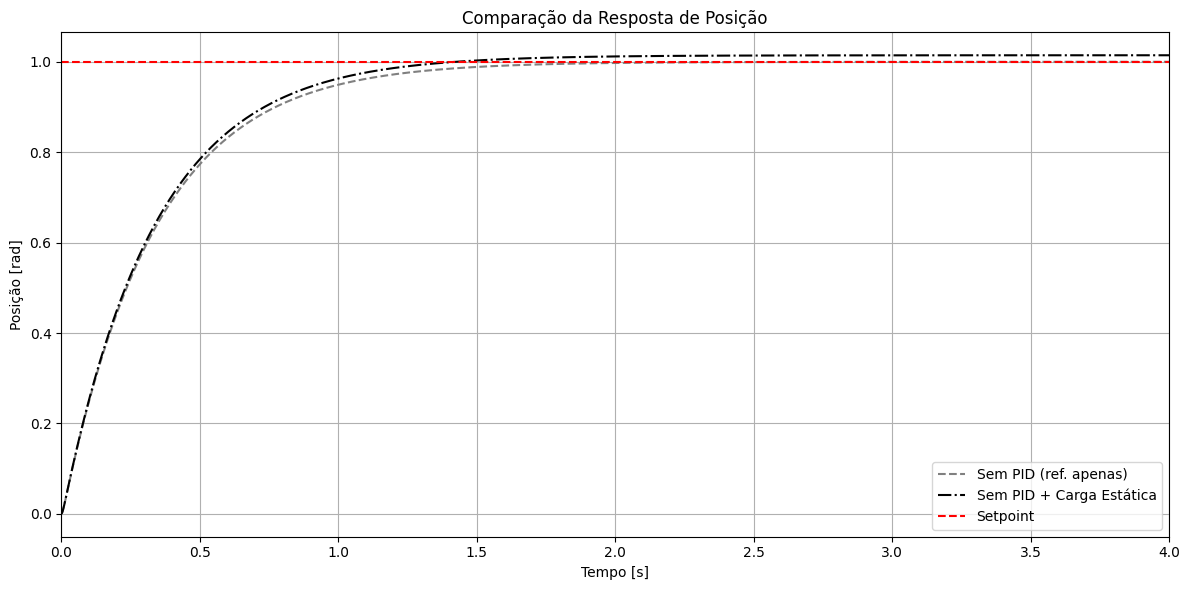

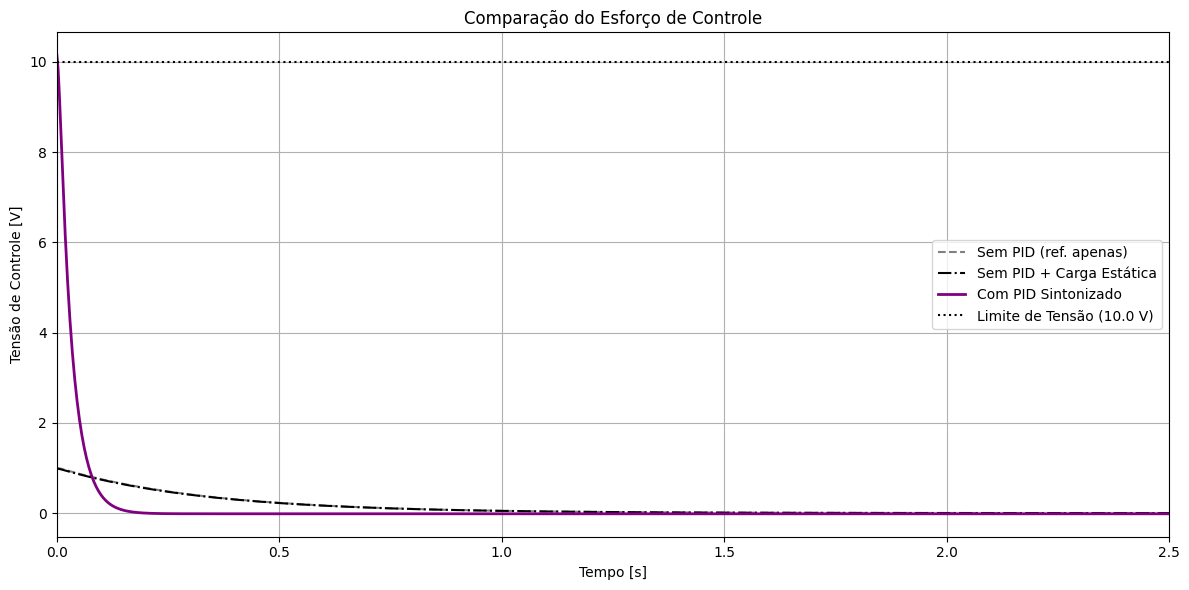

In [10]:
# --- Simulação sem PID ---
# TFs do sistema sem PID
T_r_initial = ct.feedback(G_pos, 1)      # Referência -> posição (sem controlador)
T_d_initial = ct.feedback(G_pos, 1)      # Torque -> posição (sem controlador)
T_u_initial = ct.feedback(1, G_pos)      # Referência -> esforço de controle (sem controlador)

# Tempo de simulação 
t_inicial = t.copy()

# 1) Resposta à referência (sem PID)
_, y_inicial = ct.step_response(T_r_initial, T=t_inicial)

# 2) Resposta à carga (torque constante)
torque_input = tau_load * np.ones_like(t_inicial)
_, y_dist_initial = ct.forced_response(T_d_initial, T=t_inicial, U=torque_input)
y_inicial_total = y_inicial + y_dist_initial

# 3) Esforço de controle (sem PID)
_, u_inicial = ct.forced_response(T_u_initial, T=t_inicial, U=np.ones_like(t_inicial))
_, u_dist_initial = ct.forced_response(-T_u_initial, T=t_inicial, U=torque_input)
u_inicial_total = u_inicial + u_dist_initial
u_final = ct.forced_response(C_pid, T=t, U=(1 - y)).outputs


# --- Figura 1: Resposta de Posição ---
plt.figure(figsize=(12, 6))
plt.plot(t_inicial, y_inicial, '--', color='grey', label='Sem PID (ref. apenas)')
plt.plot(t_inicial, y_inicial_total, '-.', color='black', label='Sem PID + Carga Estática')
# plt.plot(t, y, '-', color='blue', linewidth=2, label='Com PID Sintonizado')  # 'y' é y_ref + y_dist com PID
plt.axhline(1.0, color='r', linestyle='--', label='Setpoint')
plt.xlabel("Tempo [s]")
plt.ylabel("Posição [rad]")
plt.title("Comparação da Resposta de Posição")
plt.legend()
plt.grid(True)
plt.xlim(0, 4)
plt.tight_layout()

# --- Figura 2: Esforço de Controle ---
plt.figure(figsize=(12, 6))
plt.plot(t_inicial, u_inicial, '--', color='grey', label='Sem PID (ref. apenas)')
plt.plot(t_inicial, u_inicial_total, '-.', color='black', label='Sem PID + Carga Estática')
plt.plot(t, u_final, '-', color='purple', linewidth=2, label='Com PID Sintonizado')
plt.axhline(targets["control_effort"], color='k', linestyle=':',
            label=f'Limite de Tensão ({targets["control_effort"]} V)')
plt.xlabel("Tempo [s]")
plt.ylabel("Tensão de Controle [V]")
plt.title("Comparação do Esforço de Controle")
plt.legend()
plt.grid(True)
plt.xlim(0, 2.5)
plt.tight_layout()

plt.show()
